In [1]:
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

In [2]:
%load_ext autoreload
%autoreload 2
from tasks.dsm_diffusion import DSMDiffusion
import torch
import matplotlib.pyplot as plt
from data.diffusion import LatentDiffusionDataset
from data.hmm import MetaHMM
from torch2jax import j2t, t2j
import jax.numpy as jnp
import jax
from jax.scipy.special import rel_entr
from einops import repeat, rearrange
from models.encoder import KnownEncoder
from models.decoder import TransformerDecoder
from tqdm import tqdm
from tasks.metalearn import MetaLearningTask
import torch.nn as nn
import pandas as pd
import seaborn as sns
import einx
import wandb
import pandas as pd
import seaborn as sns
import numpy as np

In [10]:
# Style for making nice-looking paper plots with page-scale figure size units
sns.set_theme(
    style="ticks",
    context="paper",
    rc={
        "font.size": 10,
        "axes.titlesize": 30,
        "axes.labelsize": 25,
        "axes.labelpad": 2,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
        "legend.title_fontsize": 4.5,
        "legend.fontsize": 4.5,
        "legend.markerscale": 0.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.4,
        "xtick.major.width": 0.4,
        "ytick.major.width": 0.4,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,
        "xtick.minor.width": 0.2,
        "ytick.minor.width": 0.2,
        "figure.constrained_layout.use": True,
        "figure.dpi": 200,
    },
)

# Transformer VS Bayesian Oracle

In [92]:
runs = wandb.Api().runs(
    path="guillaume-lajoie/latent_control",
    filters={
        "$or": [
            {"config.sweep_id": "workshop-implicit-gpt2025-05-09-13-32-15"},
            {"config.sweep_id": "workshop-implicit-gpt-12025-05-11-23-11-56"}
        ]
    },
)
runs = [run.id for run in runs]

In [93]:
task = MetaLearningTask.load_from_checkpoint(
        f"/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/{runs[0]}/last.ckpt", strict=False
    )

In [94]:
len(task.data)

12288

In [12]:
full_df = pd.DataFrame()

for run_id in runs:
    task = MetaLearningTask.load_from_checkpoint(
        f"/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/{run_id}/last.ckpt", strict=False
    )
    pp_out = task.evaluate_pp(samples=300, n_steps=200)

    jensen_div = pp_out['BackwardKL'] +  pp_out['ForwardKL']
    task_df = pd.DataFrame(jensen_div)
    task_df["Size"] = task.model.cfg.tag
    task_df["Seed"] = task.data.cfg.seed
    task_df = task_df.melt(id_vars=["Size", "Seed"], var_name="Context length", value_name="JensenDiv")

    full_df = pd.concat([full_df, task_df], ignore_index=True)

300it [02:24,  2.07it/s]
300it [02:25,  2.07it/s]
300it [02:24,  2.07it/s]


In [4]:
full_df = pd.read_csv('data.csv')

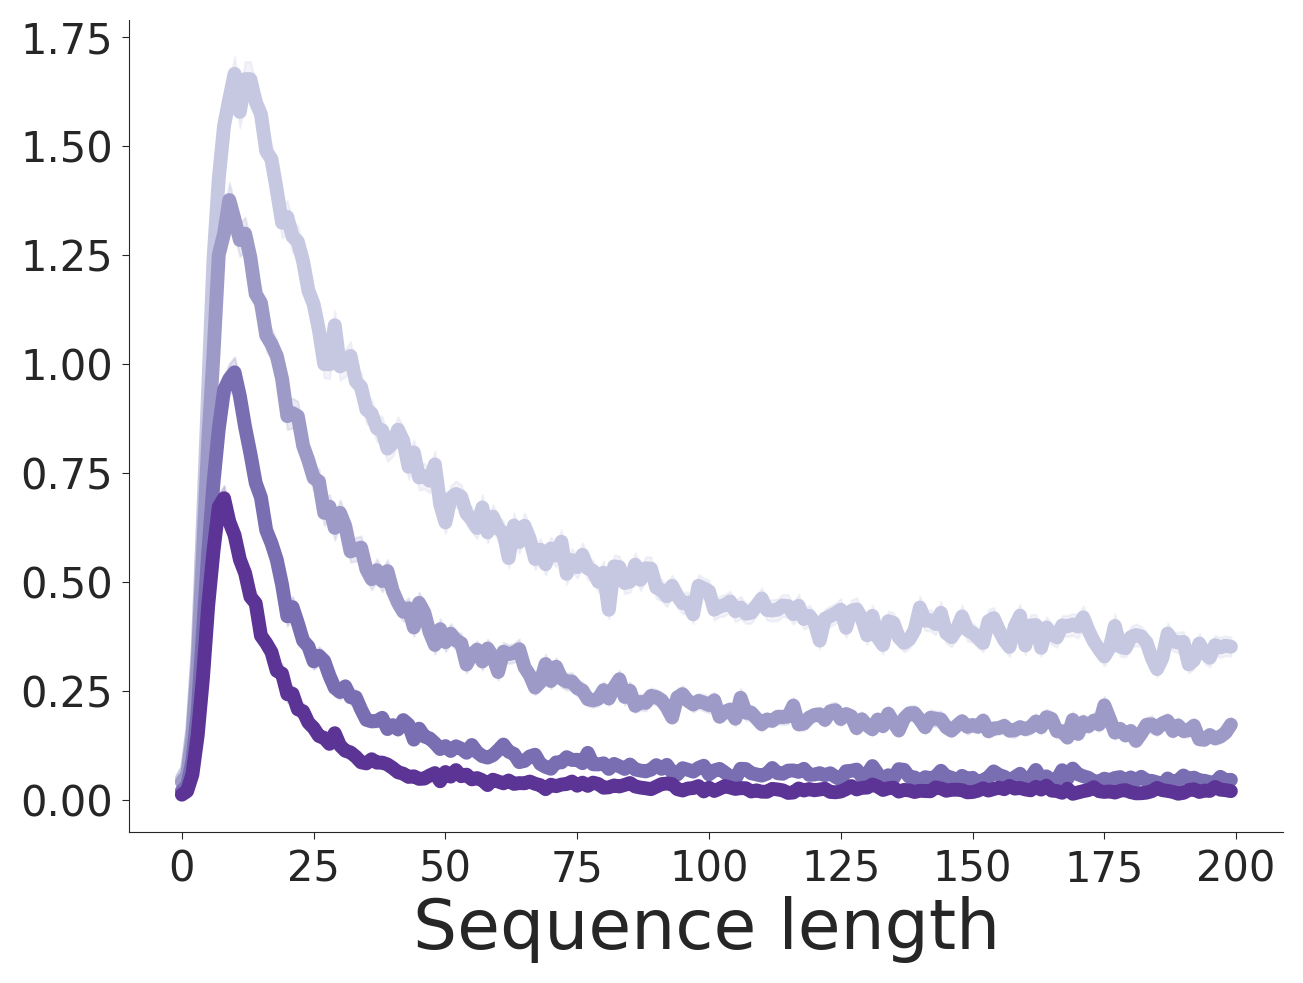

In [17]:
# full_df = pd.read_csv("data.csv")
ax = sns.lineplot(
    full_df,
    x="Context length",
    y="JensenDiv",
    hue="Size",
    errorbar="se",
    hue_order=["gpt_small", "gpt_small_1", "gpt_med", "gpt_large"],
    palette=sns.color_palette("Purples", 5)[1:],
    linewidth=5
)
ax.set(xlabel='Sequence length', ylabel='')
ax.get_legend().remove()

# Skewed distribution

In [4]:
runs = wandb.Api().runs(
    path="guillaume-lajoie/latent_control",
    filters={
        "$or": [
            {"config.sweep_id": "workshop-implicit-skewed2025-05-14-16-49-50"},
        ]
    },
)
runs = [run.id for run in runs]

In [ ]:
full_df = pd.DataFrame()

for run_id in runs:
    task = MetaLearningTask.load_from_checkpoint(
        f"/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/{run_id}/last.ckpt", strict=False
    )
    pp_out = task.evaluate_pp(samples=300, n_steps=200)

    jensen_div = (pp_out['BackwardKL'] +  pp_out['ForwardKL'])*0.5
    task_df = pd.DataFrame(jensen_div)
    task_df["Size"] = task.model.cfg.tag
    task_df["Seed"] = task.data.cfg.seed
    task_df = task_df.melt(id_vars=["Size", "Seed"], var_name="Context length", value_name="JensenDiv")

    full_df = pd.concat([full_df, task_df], ignore_index=True)

In [90]:
full_df = pd.read_csv('data_skewed.csv')

[Text(0.5, 0, 'Sequence length'), Text(0, 0.5, 'Div')]

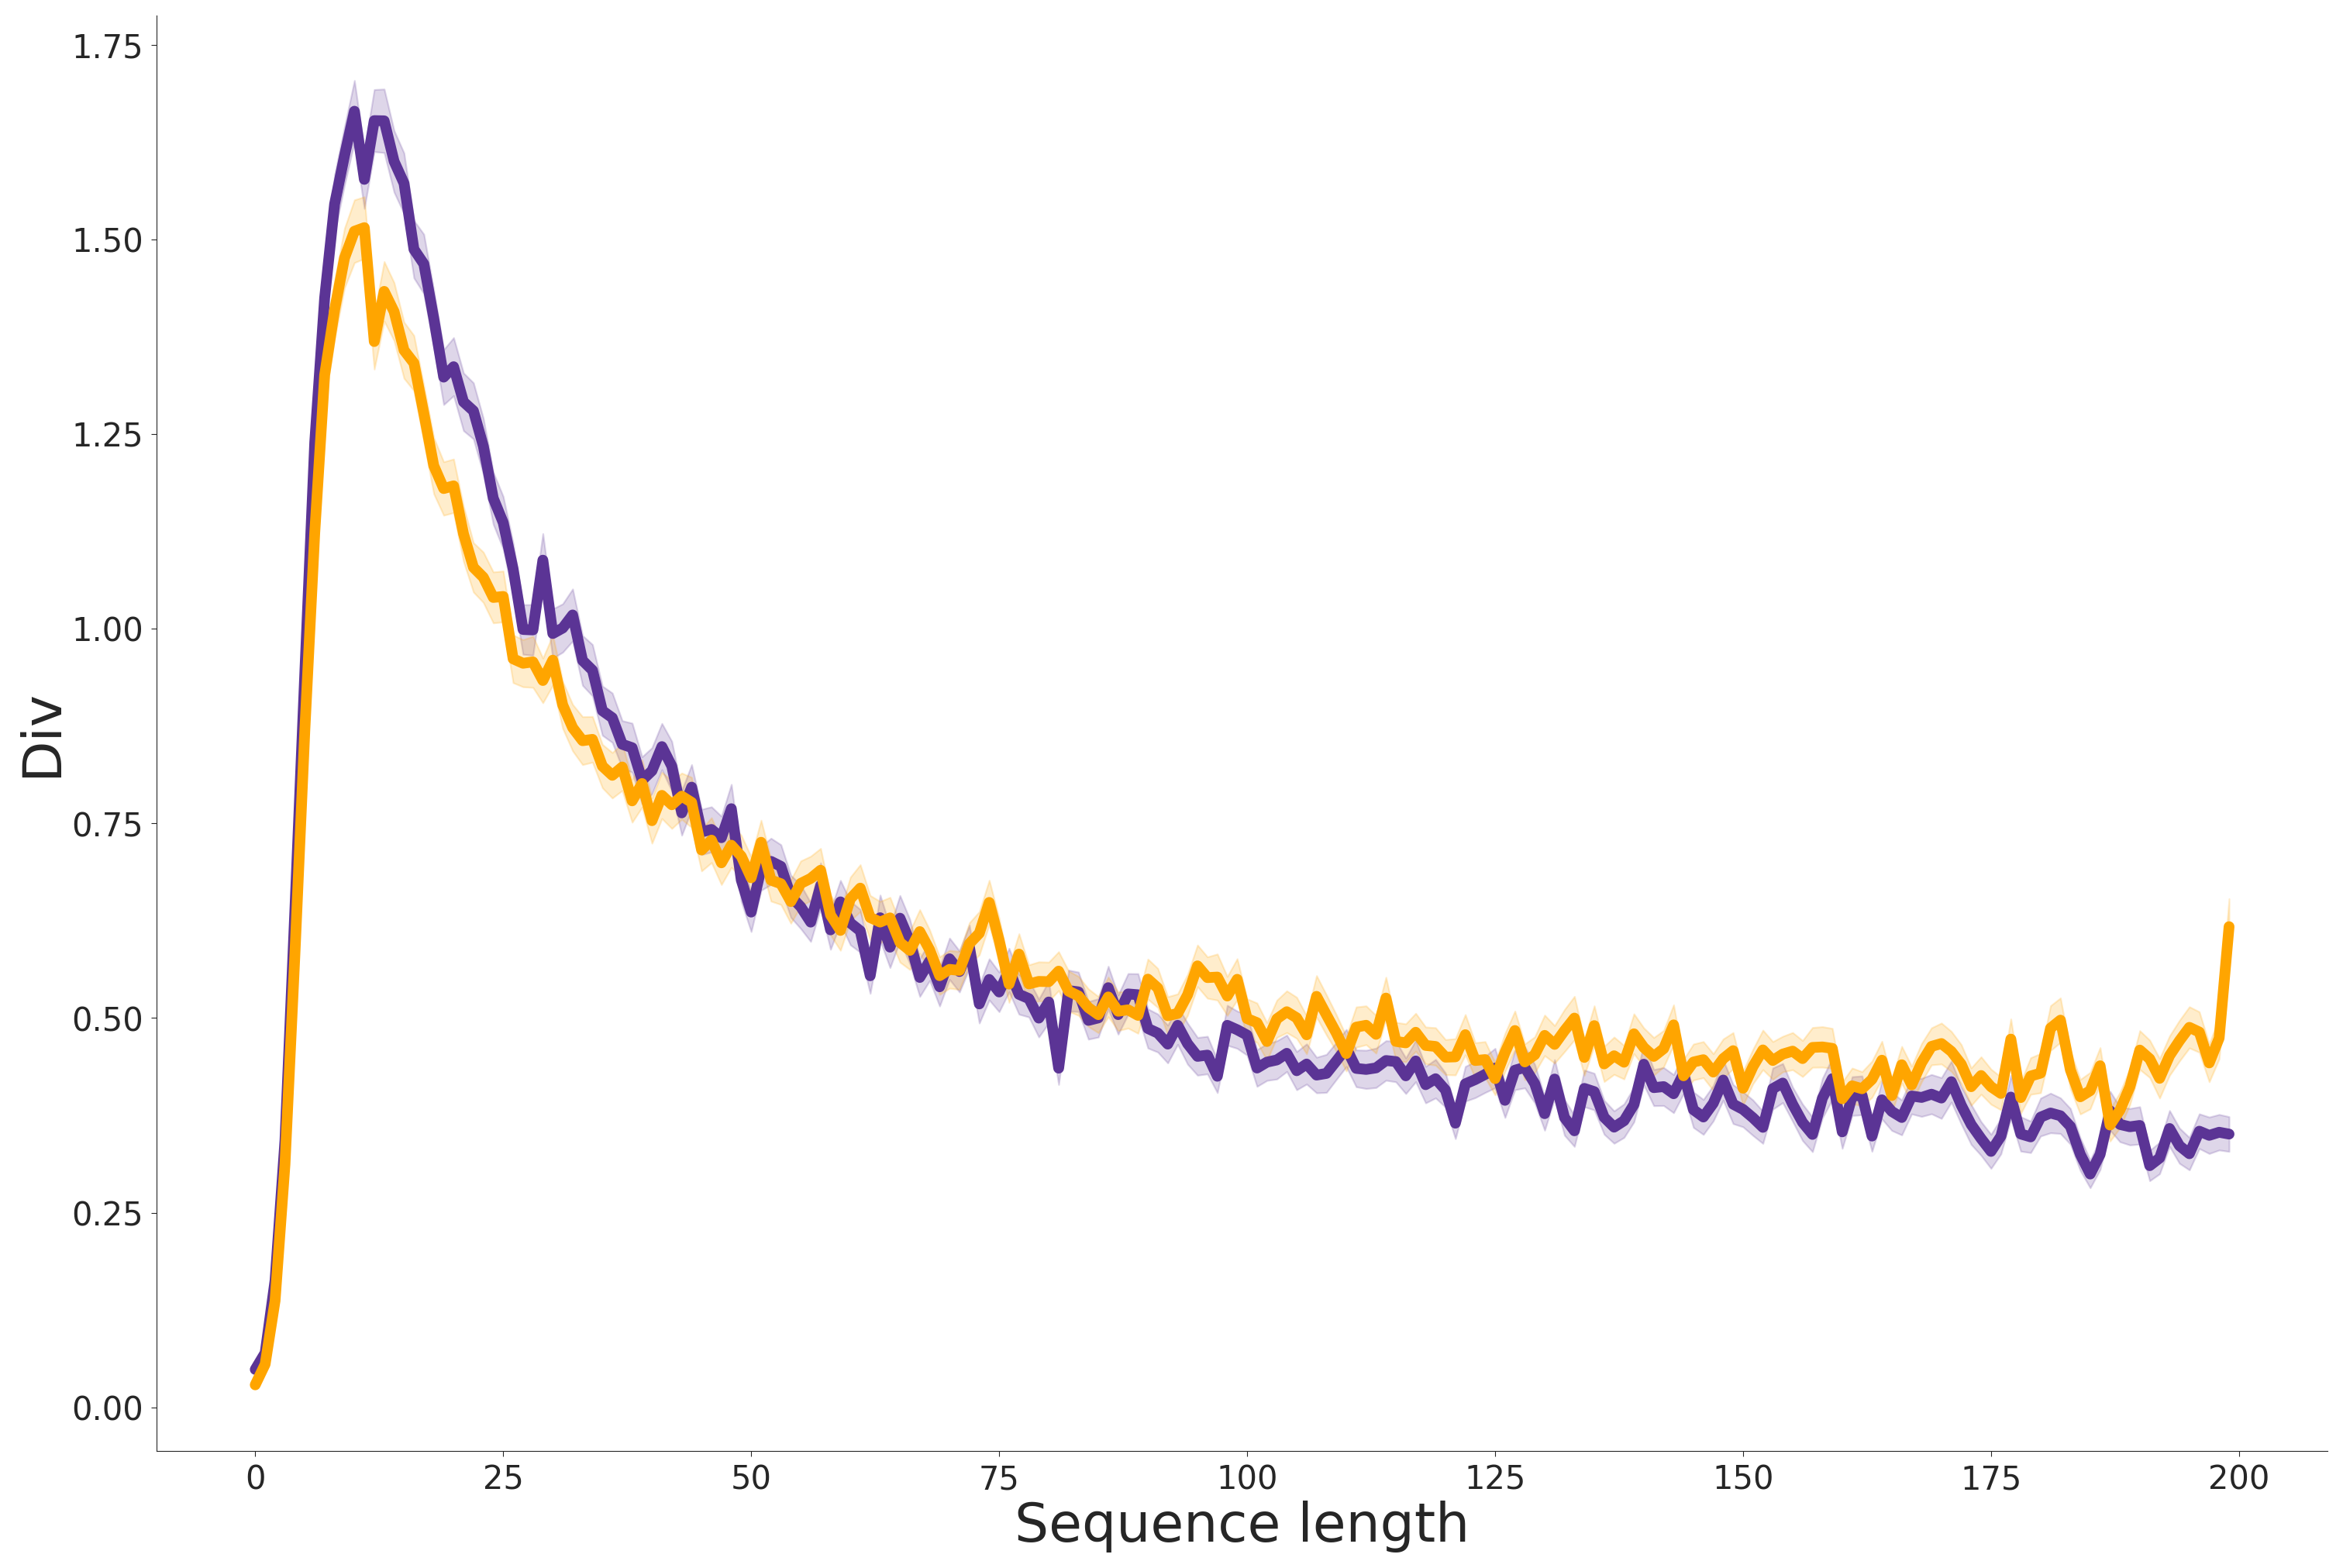

In [91]:
plt.figure(figsize=(15,10))

# full_df = pd.read_csv("data.csv")
ax = sns.lineplot(
    full_df,
    x="Context length",
    y="JensenDiv",
    hue="Type",
    errorbar="se",
    palette=[sns.color_palette("Purples", 5)[4], "orange"],
    linewidth=5
)
ax.get_legend().remove()
ax.set(xlabel='Sequence length', ylabel='Div')

# Diffusion

In [13]:
runs = wandb.Api().runs(
    path="guillaume-lajoie/latent_control",
    filters={
        "$or": [
            {"config.sweep_id": "workshop-diffusion2025-05-10-23-46-46"},
        ]
    },
)
runs = [run.id for run in runs]

In [16]:
N_SEQS = 50
N_SAMPLES = 5

In [17]:
full_df = pd.DataFrame()

for run_id in runs:
    for n_samples in [5]:

        task = DSMDiffusion.load_from_checkpoint(
            f"/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/{run_id}/last.ckpt",
            strict=False,
        )
        task.cfg.sampling_timesteps = 200

        if task.dataset.task.model.encoder.backbone.cfg.n_embd != 512:
            continue
        if task.dataset.task.data.cfg.seed == 15:
            continue

        # Generate some short sequences
        dataset = task.dataset.metahmm
        hmms = torch.randperm(len(dataset))[:N_SEQS]
        batch = dataset.__getitems__(hmms, length=50)

        # Compute the implicit posterior predictive
        implicit_task = MetaLearningTask.load_from_checkpoint(
            f"/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/{task.dataset.task.model.encoder.cfg.pretrained_id}/last.ckpt",
            strict=False,
        ).cuda()
        implicit_pred = (
            torch.nn.functional.softmax(implicit_task.model(batch["input_ids"]), dim=-1)
            .cpu()
            .detach()
        )
        del implicit_task

        # Compute the monte-carlo estimates
        mc_out = task.evaluate_mc_estimate(
            cond_input_ids=batch['input_ids'],
            n_samples=n_samples,
            max_seqs=N_SEQS,
            full_metrics=True,
            implicit_pred=implicit_pred
            )
        
        df_0 = pd.DataFrame(mc_out['jensen_div'])
        df_0["Model"] = "MC-estimate"
        df_0["Size"] = task.dataset.task.model.encoder.backbone.cfg.n_embd
        df_0["Seed"] = task.dataset.task.data.cfg.seed
        df_0["Prefix length"] =  task.dataset.task.model.encoder.cfg.context_length
        df_0["Samples"] = n_samples

        df_1 = pd.DataFrame(mc_out['jensen_div_implicit'])
        df_1["Model"] = "Implicit"
        df_1["Size"] = task.dataset.task.model.encoder.backbone.cfg.n_embd
        df_1["Seed"] = task.dataset.task.data.cfg.seed

        task_df = pd.concat([df_0, df_1], ignore_index=True).melt(
            id_vars=["Size", "Seed", "Prefix length", "Model", "Samples"], var_name="Context length", value_name="JensenDiv"
        )

        full_df = pd.concat([full_df, task_df], ignore_index=True)

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:595: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4252: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
100%|██████████| 50/50 [10:54<00:00, 13.08s/it]
/home/mila/l/leo.gagnon/latent_control/data/hmm.py:595: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)
100%|██████████| 50/50 [10:50<00:00, 13.02s/it]
/home/mila/l/leo.gagnon/latent_control/data/hmm.py:595: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will

In [83]:
full_df = pd.read_csv("data_diffusion_real1.csv")

In [69]:
full_df.loc[full_df["Size"] == "Large", "Size"] = "25.0M"

In [70]:
full_df["Size"].unique()

array(['25.0M', '6.3M', '1.1M', '2.0M'], dtype=object)

[Text(0.5, 0, 'Model size'), Text(0, 0.5, ''), (0.0, 2.5)]

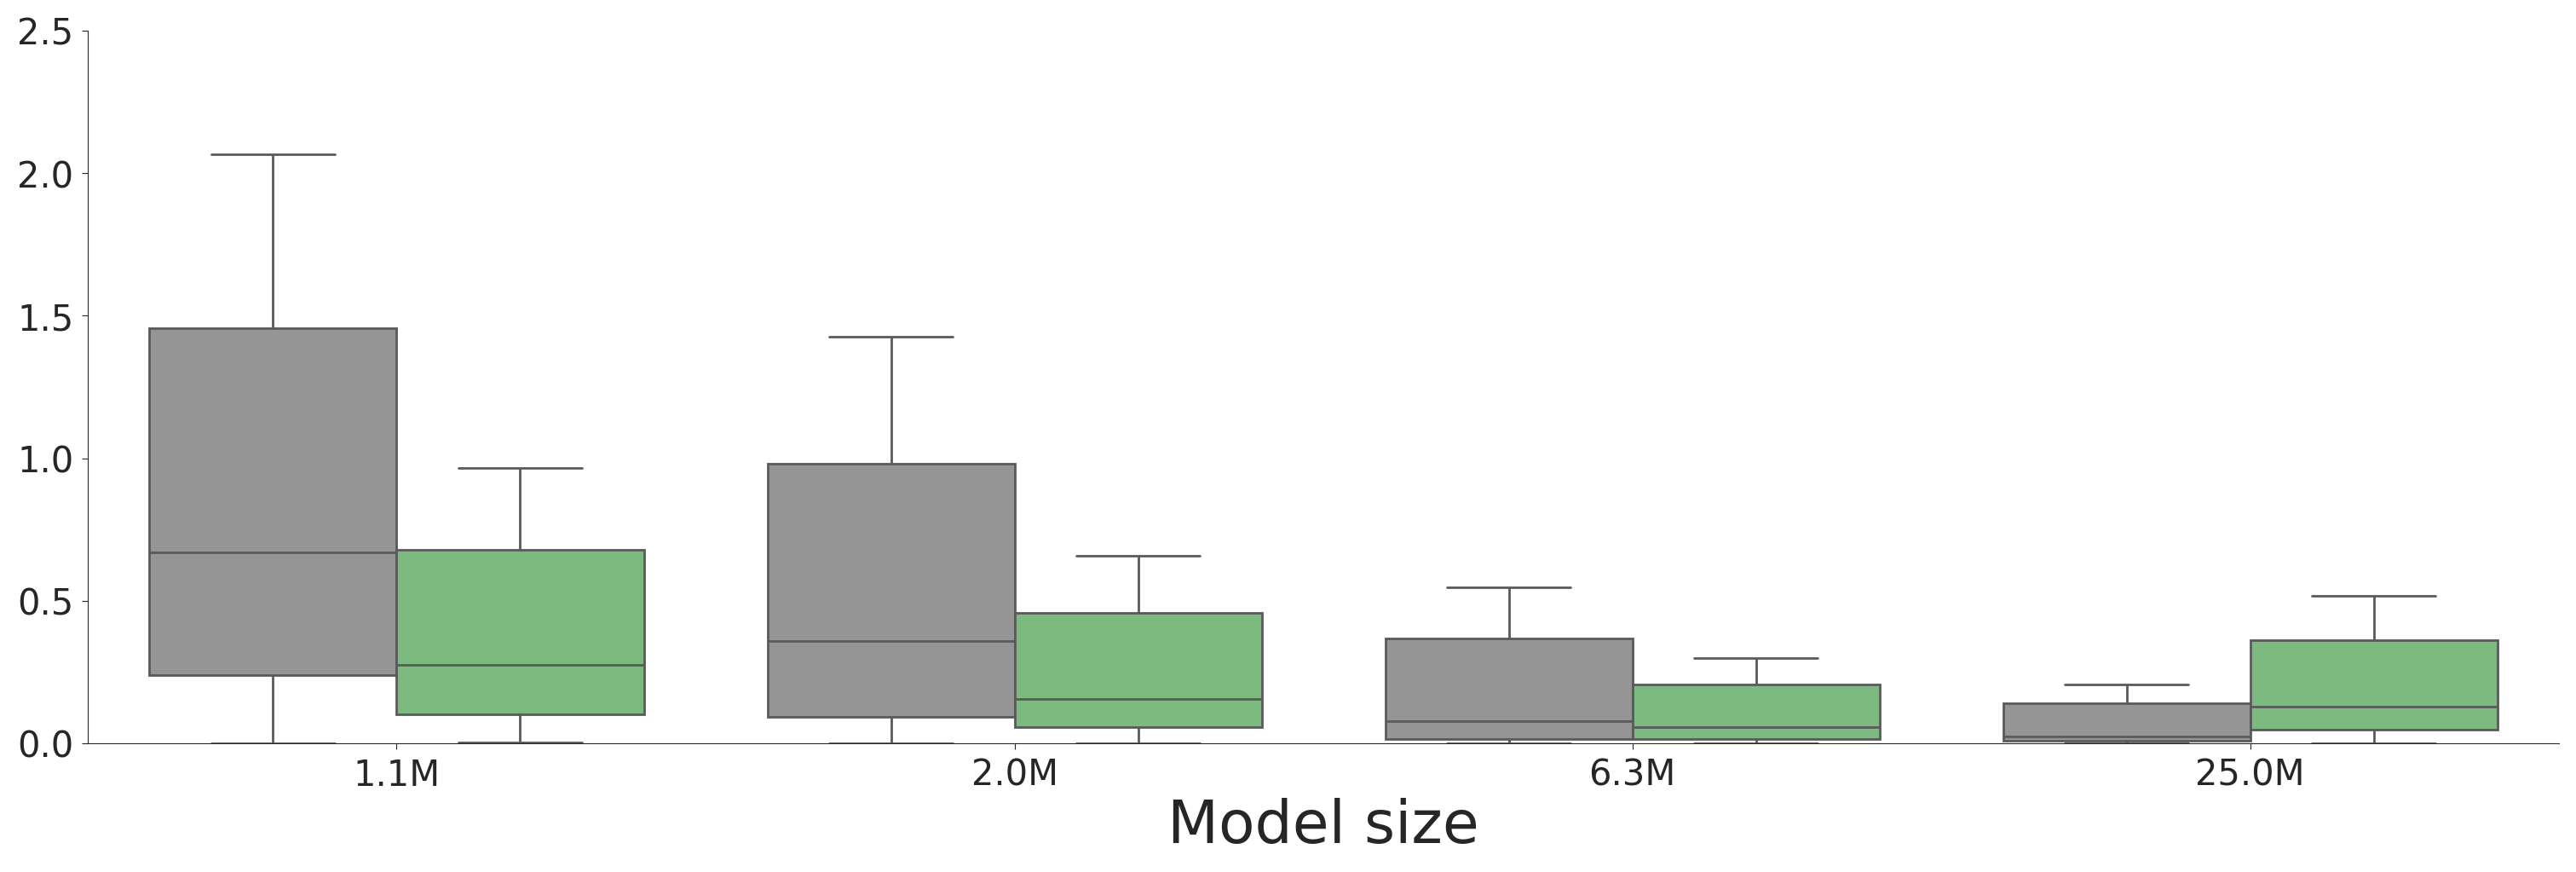

In [84]:
plt.figure(figsize=(15,5))

ax = sns.boxplot(
    full_df[
        ((full_df["Samples"] == '50.0')
        | (full_df["Samples"] == "none"))
        & (full_df["Prefix length"] != '10.0')
    ],
    x="Size",
    y="JensenDiv",
    hue="Model",
    order=["1.1M", "2.0M", "6.3M", "25.0M"],
    dodge=True,
    showfliers=False,
    whis=0.5,
    palette=[sns.color_palette("Greys", 5)[2], sns.color_palette("Greens", 5)[2]]
)
ax.get_legend().remove()
ax.set(xlabel='Model size', ylabel='', ylim=[0,2.5])

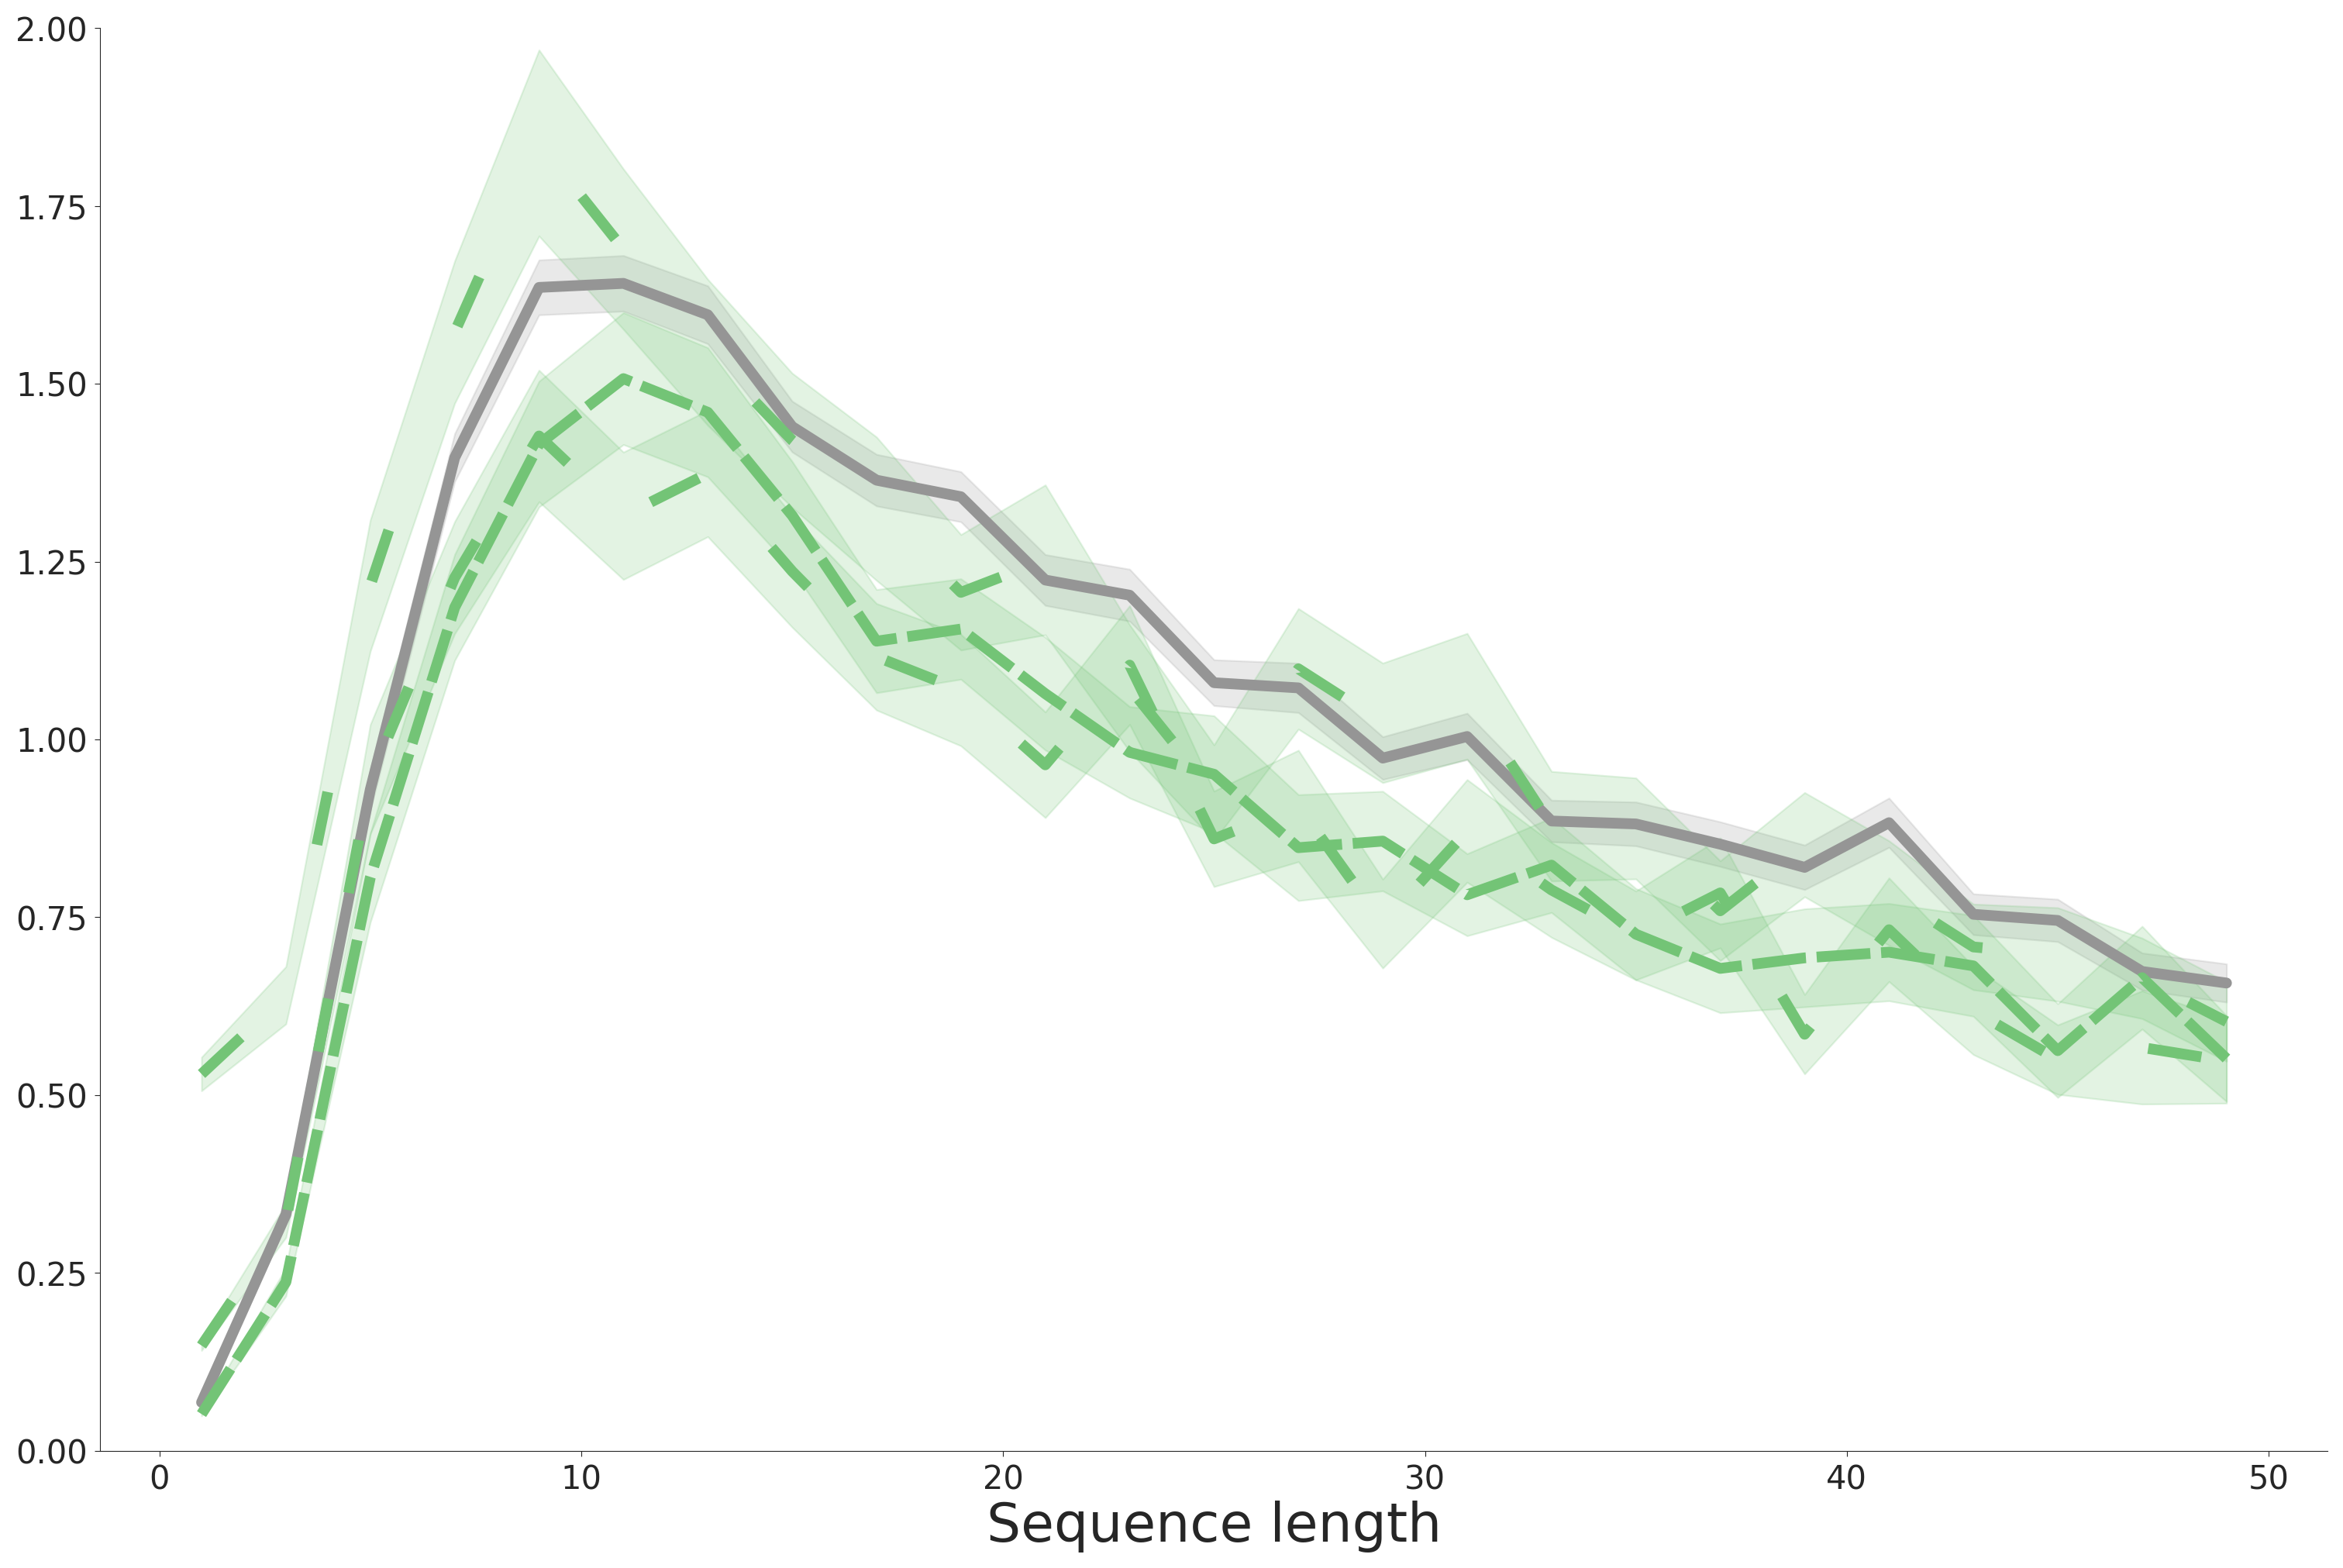

In [89]:
plt.figure(figsize=(15,10))


ax = sns.lineplot(
    full_df[
        (full_df["Size"] == "1.1M")
        & (full_df["Prefix length"] != '100.0')
        & (full_df["Context length"])
    ],
    x="Context length",
    errorbar="se",
    y="JensenDiv",
    hue="Samples",
    palette=[sns.color_palette("Greys", 5)[2],sns.color_palette("Greens", 5)[2], sns.color_palette("Greens", 5)[2], sns.color_palette("Greens", 5)[2]],
    hue_order=['none', '1.0', '5.0', '50.0'],
    linewidth=5

)
ax.set(xlabel='Sequence length', ylabel='' ,ylim=[0,2])

if True:
    ax.get_legend().remove()

    labels = ['_child0',
    '_child2',
    '_child4',
    '_child6']
    styles = [
        '-',
        (0, (5, 20)),
        (0, (5, 10)),
        (0, (5, 1)),
    ]

    label_to_style = {label: styles[i % len(styles)] for i, label in enumerate(labels)}

    for line in ax.lines:
        label = line.get_label()
        if label in label_to_style:
            line.set_linestyle(label_to_style[label])

    plt.show()